In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
import os
from os import chdir as cd
import warnings
import cv2
import pickle
import random
from matplotlib import gridspec   
from matplotlib import cm
from scipy import interpolate
from scipy import stats, ndimage
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tqdm import tqdm
from sklearn.decomposition import PCA
from scipy.stats import stats
import itertools
import functools
from functools import partial
from tensorflow.keras import backend as K 
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.metrics import top_k_categorical_accuracy as tCA
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import CategoricalCrossentropy, binary_crossentropy, mse
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras.layers import add, concatenate, multiply, Layer
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, GlobalMaxPooling2D, Reshape , Lambda , Add, Multiply, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization, MaxPooling2D, Flatten, GlobalAveragePooling2D, Activation, AveragePooling2D , ZeroPadding2D, SeparableConv2D, Dropout
from tensorflow.keras.models import Model, load_model , Sequential, save_model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler, ModelCheckpoint, CSVLogger, Callback, ReduceLROnPlateau
warnings.filterwarnings("ignore")

In [ ]:
cd("/content/drive/Shareddrives/Mylab/src")
from lrn import LRN
from f1score import macro_f1score
labels = ['Center','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch','none']

# **CPU Info**

In [ ]:
!cat /proc/cpuinfo

# **Preprocessing**

In [ ]:
sub_df = pd.read_pickle("main3.pkl")

In [ ]:
sub_df.head()

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,150,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
1,151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
2,152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
3,153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
4,154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0


In [ ]:
sub_df.shape

(33173, 9)

In [ ]:
sub_df = sub_df.loc[(sub_df['failureType'] != 'Donut')]
sub_df.shape

(33164, 9)

In [ ]:
# Arrange data
sw = np.ones((1, 32, 32))
label = list()

for i in tqdm(range(len(sub_df))):
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 32, 32)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [ ]:
# Resize class 'none'
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=25000, replace=False)]
new_x = np.delete(x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

In [ ]:
# For CNN models
x = np.zeros((len(new_x), 32, 32, 3))
for w in tqdm(range(len(new_x))):
    for i in range(32):
        for j in range(32):
            x[w, i, j, int(new_x[w, i, j])] = 1

x.shape

In [ ]:
# Stratified train/test split
x_train, x_test, y_train, y_test = train_test_split(x, new_y, test_size=0.2, random_state=123, stratify=new_y)

In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f])))

In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_test[y_test==f])))

In [ ]:
print('{},{}'.format(x_train.shape, y_train.shape))

In [ ]:
# saving preprocessed x and y
dataset = {"y_train": y_train, "y_test": y_test, "x_train": x_train, "x_test": x_test}
with open('dataset.pickle', 'wb') as file:
    pickle.dump(dataset, file)

# **PCA**

In [ ]:
with open('dataset.pickle', 'rb') as file:
    dataset = pickle.load(file)
x_test = dataset.get("x_test")
x_train = dataset.get("x_train")
y_train = dataset.get("y_train")
y_test = dataset.get("y_test")

In [ ]:
x_test[0].shape # 32x32 그림: 32개의 row, 하나당 32개의 col, 각 픽셀당 3가지 색상 중 하나

(32, 32, 3)

In [ ]:
x_test[0][0]

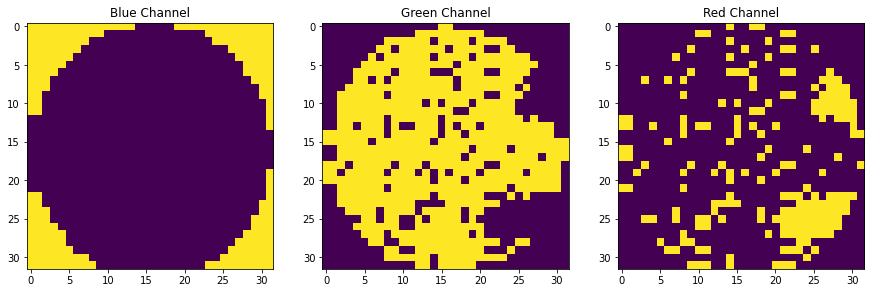

In [ ]:
#Splitting into 3 channels
blue,green,red = cv2.split(x_train[19])
# Plotting the images
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(blue)
fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)
fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)
plt.show()

In [ ]:
# PCA with 8 components
pca_b = PCA(n_components=8)
pca_b.fit(blue)
trans_pca_b = pca_b.transform(blue)
pca_g = PCA(n_components=8)
pca_g.fit(green)
trans_pca_g = pca_g.transform(green)
pca_r = PCA(n_components=8)
pca_r.fit(red)
trans_pca_r = pca_r.transform(red)

In [ ]:
print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

Blue Channel : 0.966586306448865
Green Channel: 0.7215829248001393
Red Channel  : 0.5958015786842809


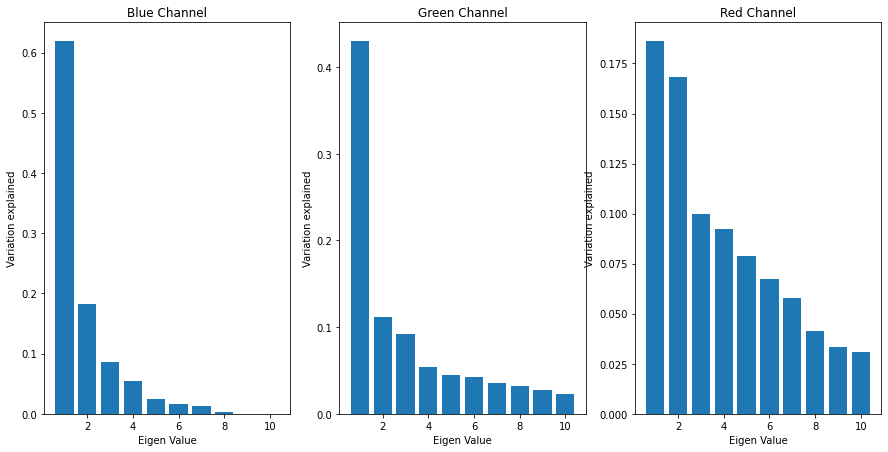

In [ ]:
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,11)),pca_b.explained_variance_ratio_)
fig.add_subplot(132)
plt.title("Green Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,11)),pca_g.explained_variance_ratio_)
fig.add_subplot(133)
plt.title("Red Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,11)),pca_r.explained_variance_ratio_)
plt.show()

In [ ]:
# Reconstructing the image
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)

In [ ]:
img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
print(img_reduced.shape)

(32, 32, 3)


In [ ]:
# Add random noise
def parse(ary):
  A = np.where(ary == max(ary), 1, 0)
  if np.random.binomial(1,p=0.03) == 1:
    A[1] = 0 if A[1]==1 else A[1]
    A[2] = 1 if A[0]==0 and A[1]==0 and A[2]==0 else A[2]
  return A

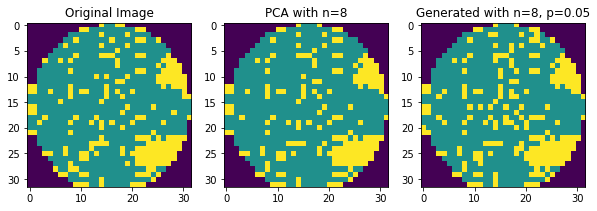

In [ ]:
fig = plt.figure(figsize = (10, 7.2))
fig.add_subplot(131)
plt.title("Original Image")
plt.imshow(np.argmax(x_train[19], axis=2))
fig.add_subplot(132)
plt.title("PCA with n=8")
plt.imshow(np.argmax(img_reduced, axis=2))
fig.add_subplot(133)
plt.title("Generated with n=8, p=0.05")
plt.imshow(np.argmax(np.array([np.array(list(map(parse, ary))) for ary in img_reduced]), axis=2))
plt.show()

In [ ]:
# Data Augmentation
def gen_pca(wafer):
  blue,green,red = cv2.split(wafer)
  b_arr_ = pca.fit_transform(blue)
  b_arr = pca.inverse_transform(b_arr_)
  g_arr_ = pca.fit_transform(green)
  g_arr = pca.inverse_transform(g_arr_)
  r_arr_ = pca.fit_transform(red)
  r_arr = pca.inverse_transform(r_arr_)
  gen = (cv2.merge((b_arr, g_arr, r_arr)))
  return gen

def gen_data(wafer, label, n=8):
    gen_x = np.zeros((1, 32, 32, 3))
    global pca
    pca = PCA(n_components=n)

    for i in tqdm(range((1000//len(wafer)) + 1)):
      pca_gen_x = np.zeros((len(wafer), 32, 32, 3))
      for j in range(len(wafer)):
        pca_gen_x[j] = np.array([np.array(list(map(parse, ary))) for ary in gen_pca(wafer[j])])
      gen_x = np.concatenate((gen_x, pca_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    return gen_x[1:], gen_y[1:]

def rot_data(wafer, label):
    rot_x = np.zeros((1, 32, 32, 3))

    for i in tqdm(range(5000 - len(y_train[y_train==label]))):
        n = np.random.randint(len(wafer))
        roted_gen_x = ndimage.rotate(x_train[np.where(y_train==label)[0][n]], np.random.randint(360), axes=(0,1), mode='constant', order = 0, reshape=False).reshape(1,32,32,3)
        rot_x = np.concatenate((rot_x, roted_gen_x), axis=0)
    rot_y = np.full((len(rot_x), 1), label)
    return rot_x[1:], rot_y[1:]

In [ ]:
x_train_org = x_train.copy()
y_train_org = y_train.copy()
for f in labels :  
    if f == 'none' : 
        continue    
    gen_x, gen_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, gen_x), axis=0)
    y_train = np.concatenate((y_train, gen_y))

for f in labels :  
    if f == 'none' : 
        continue    
    rot_x, rot_y = rot_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, rot_x), axis=0)
    y_train = np.concatenate((y_train, rot_y))

100%|██████████| 3889/3889 [00:56<00:00, 69.19it/s]


In [ ]:
print('After Generating new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generating new x shape : (40310, 32, 32, 3), new y shape : (40310, 1)


In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

Center : 5000
Edge-Loc : 5000
Edge-Ring : 5000
Loc : 5000
Near-full : 5000
Random : 5000
Scratch : 5000
none : 5310


In [ ]:
def shuffle_two(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
x_train, y_train = shuffle_two(x_train, y_train)

In [ ]:
x_test, y_test = shuffle_two(x_test, y_test)

In [ ]:
np.where(y_train=='Edge-Ring')

(array([    8,    11,    12, ..., 40266, 40292, 40303]),
 array([0, 0, 0, ..., 0, 0, 0]))

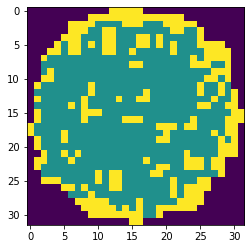

In [ ]:
plt.imshow(np.argmax(x_train[8], axis=2))

In [ ]:
dataset_pca_noise = {"y_train": y_train, "y_test": y_test, "x_train": x_train, "x_test": x_test}

# **Convolutional AE**

In [ ]:
with open('dataset.pickle', 'rb') as file:
    dataset = pickle.load(file)
x_test = dataset.get("x_test")
x_train = dataset.get("x_train")
y_train = dataset.get("y_train")
y_test = dataset.get("y_test")

In [ ]:
def encoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(padding='same')(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(padding='same')(conv2) # 8 x 8 x 64
    return pool2

def decoder(conv4):
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4) # 8 x 8 x 64
    up1 = UpSampling2D()(conv5) # 16 x 16 x 64
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D()(conv6)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) # 32 x 32 x 1
    return decoded

input_shape = Input(shape=(32, 32, 3))
def CAE(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='conv1', input_shape=input_shape))
    model.add(MaxPooling2D(padding='same'))
    model.add(Conv2DTranspose(64, (3,3), padding='same', activation='relu', name='deconv2'))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(3, (3,3), padding='same', name='deconv1'))
    return model

In [ ]:
AEncoder = CAE()
AEncoder.summary()
AEncoder.compile(loss='mse', optimizer='adam')
AEncoder.fit(x_train, x_train, epochs=50, batch_size=500, verbose=2)

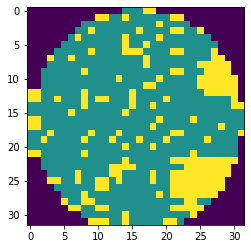

In [ ]:
gen_x = np.argmax(AEncoder.predict(x_train), axis=3)
plt.imshow(gen_x[19])

In [ ]:
# Generate data
def gen_data(wafer, label):
    gen_x = np.zeros((1, 32, 32, 3))
    for i in tqdm(range((1000//len(wafer)) + 1)):
        noised_encoded_x = wafer + np.random.normal(loc=0, scale=0.1, size = (len(wafer), 32, 32, 3))  
        noised_gen_x = AEncoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    return gen_x[1:], gen_y[1:]

def rot_data(wafer, label):
    rot_x = np.zeros((1, 32, 32, 3))
    for i in tqdm(range(5000 - len(y_train[y_train==label]))):
        n = np.random.randint(len(wafer))
        roted_gen_x = ndimage.rotate(x_train[np.where(y_train==label)[0][n]], np.random.randint(360), axes=(0,1), mode='constant', order = 0, reshape=False).reshape(1,32,32,3)
        rot_x = np.concatenate((rot_x, roted_gen_x), axis=0)
    rot_y = np.full((len(rot_x), 1), label)
    return rot_x[1:], rot_y[1:]

In [ ]:
x_train_org = x_train.copy()
y_train_org = y_train.copy()
for f in labels :  
    if f == 'none' : 
        continue    
    gen_x, gen_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, gen_x), axis=0)
    y_train = np.concatenate((y_train, gen_y))

for f in labels :  
    if f == 'none' : 
        continue    
    rot_x, rot_y = rot_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, rot_x), axis=0)
    y_train = np.concatenate((y_train, rot_y))

100%|██████████| 3889/3889 [00:59<00:00, 65.13it/s]


In [ ]:
print('After Generating new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generating new x shape : (40310, 32, 32, 3), new y shape : (40310, 1)


In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

Center : 5000
Edge-Loc : 5000
Edge-Ring : 5000
Loc : 5000
Near-full : 5000
Random : 5000
Scratch : 5000
none : 5310


In [ ]:
def shuffle_two(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
x_train, y_train = shuffle_two(x_train, y_train)

In [ ]:
x_test, y_test = shuffle_two(x_test, y_test)

In [ ]:
np.where(y_train=='Edge-Ring')

(array([   16,    30,    31, ..., 40279, 40290, 40294]),
 array([0, 0, 0, ..., 0, 0, 0]))

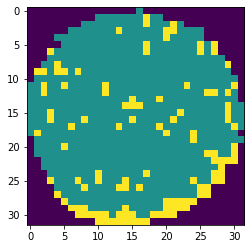

In [ ]:
plt.imshow(np.argmax(x_train[16], axis=2))

# **Denoising AE**

In [ ]:
with open('dataset.pickle', 'rb') as file:
    dataset = pickle.load(file)
x_test = dataset.get("x_test")
x_train = dataset.get("x_train")
y_train = dataset.get("y_train")
y_test = dataset.get("y_test")

In [ ]:
# denoising autoencoder
noise = np.random.normal(loc=0, scale=0.5, size=x_train.shape)
x_train_noise = x_train + noise

In [ ]:
def DAE(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='conv1', input_shape=input_shape))
    model.add(MaxPooling2D(padding='same'))
    model.add(Conv2DTranspose(64, (3,3), padding='same', activation='relu', name='conv4'))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid', name='conv5'))
    return model

In [ ]:
DAEncoder = DAE()
DAEncoder.summary()
DAEncoder.compile(loss='mse', optimizer='adam')
DAEncoder.fit(x_train_noise, x_train, epochs=50, batch_size=500, verbose=2)

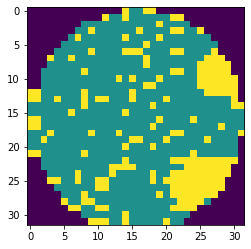

In [ ]:
x_noise = DAEncoder.predict(x_train) 
plt.imshow(np.argmax(x_noise[19], axis=2))

In [ ]:
# Generate data
def gen_data(wafer, label):
    gen_x = np.zeros((1, 32, 32, 3))
    
    for i in tqdm(range((1000//len(wafer)) + 1)):
        noised_encoded_x = wafer + np.random.normal(loc=0, scale=0.1, size = (len(wafer), 32, 32, 3))  
        noised_gen_x = DAEncoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    return gen_x[1:], gen_y[1:]

def rot_data(wafer, label):
    rot_x = np.zeros((1, 32, 32, 3))

    for i in tqdm(range(5000 - len(y_train[y_train==label]))):
        n = np.random.randint(len(wafer))
        roted_gen_x = ndimage.rotate(x_train[np.where(y_train==label)[0][n]], np.random.randint(360), axes=(0,1), mode='constant', order = 0, reshape=False).reshape(1,32,32,3)
        rot_x = np.concatenate((rot_x, roted_gen_x), axis=0)
    rot_y = np.full((len(rot_x), 1), label)
    return rot_x[1:], rot_y[1:]

In [ ]:
x_train_org = x_train.copy()
y_train_org = y_train.copy()
for f in labels :  
    if f == 'none' : 
        continue    
    gen_x, gen_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, gen_x), axis=0)
    y_train = np.concatenate((y_train, gen_y))

for f in labels :  
    if f == 'none' : 
        continue    
    rot_x, rot_y = rot_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, rot_x), axis=0)
    y_train = np.concatenate((y_train, rot_y))

100%|██████████| 3889/3889 [00:50<00:00, 76.39it/s]


In [ ]:
print('After Generate new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generate new x shape : (40310, 32, 32, 3), new y shape : (40310, 1)


In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

Center : 5000
Edge-Loc : 5000
Edge-Ring : 5000
Loc : 5000
Near-full : 5000
Random : 5000
Scratch : 5000
none : 5310


In [ ]:
def shuffle_two(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
x_train, y_train = shuffle_two(x_train, y_train)

In [ ]:
x_test, y_test = shuffle_two(x_test, y_test)

# **Variational AE**

In [ ]:
with open('dataset.pickle', 'rb') as file:
    dataset = pickle.load(file)
x_test = dataset.get("x_test")
x_train = dataset.get("x_train")
y_train = dataset.get("y_train")
y_test = dataset.get("y_test")

In [ ]:
x_train.shape

(6531, 32, 32, 3)

In [ ]:
image_size = x_train.shape[1]
original_dim = image_size * image_size * 3
x_traint = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
image_shape = (32, 32, 3)
input_shape = (original_dim, )
latent_dim = 6
batch_size = 100
epochs = 50
epsilon_std = 1.0

In [ ]:
image_shape = (32, 32, 3)
original_dim = image_shape[0] * image_shape[1] * image_shape[2]
input_shape = (original_dim,)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

inputs = Input(shape=input_shape)
x = Reshape(image_shape)(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
label_inputs = Input(shape=(original_dim,), name='label')
x = Concatenate()([latent_inputs, label_inputs])
x = Dense(128, activation='relu')(x)
x = Dense(16 * 16 * 32, activation='relu')(x)
x = Reshape((16, 16, 32))(x)
x = Dropout(0.25)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
outputs = Reshape(input_shape)(x)

decoder = Model([latent_inputs, label_inputs], outputs, name='decoder')
decoder.summary()
outputs = decoder([encoder(inputs)[2], label_inputs])
vae = Model([inputs, label_inputs], outputs, name='vae_mlp')
vae.summary()

In [ ]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.fit([x_traint, x_traint], epochs=50, batch_size=500, verbose=2)

Epoch 1/50
14/14 - 5s - loss: 330.2175 - 5s/epoch - 322ms/step
Epoch 2/50
14/14 - 2s - loss: 239.8542 - 2s/epoch - 132ms/step
Epoch 3/50
14/14 - 2s - loss: 230.9358 - 2s/epoch - 132ms/step
Epoch 4/50
14/14 - 2s - loss: 221.3994 - 2s/epoch - 133ms/step
Epoch 5/50
14/14 - 2s - loss: 215.1303 - 2s/epoch - 133ms/step
Epoch 6/50
14/14 - 2s - loss: 212.3987 - 2s/epoch - 132ms/step
Epoch 7/50
14/14 - 2s - loss: 208.8349 - 2s/epoch - 132ms/step
Epoch 8/50
14/14 - 2s - loss: 207.2728 - 2s/epoch - 132ms/step
Epoch 9/50
14/14 - 2s - loss: 206.8038 - 2s/epoch - 132ms/step
Epoch 10/50
14/14 - 2s - loss: 203.2358 - 2s/epoch - 131ms/step
Epoch 11/50
14/14 - 2s - loss: 202.1232 - 2s/epoch - 131ms/step
Epoch 12/50
14/14 - 2s - loss: 201.5441 - 2s/epoch - 131ms/step
Epoch 13/50
14/14 - 2s - loss: 200.0061 - 2s/epoch - 131ms/step
Epoch 14/50
14/14 - 2s - loss: 199.0321 - 2s/epoch - 130ms/step
Epoch 15/50
14/14 - 2s - loss: 197.2117 - 2s/epoch - 131ms/step
Epoch 16/50
14/14 - 2s - loss: 196.9601 - 2s/epoc

In [ ]:
img = np.reshape(x_traint[0], (32, 32, 3))
img = vae.predict([x_traint, x_traint])[0]
img = np.reshape(img, (32, 32, 3))

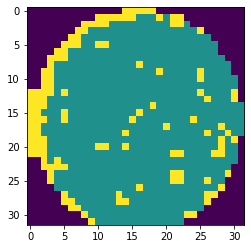

In [ ]:
plt.imshow(np.argmax(x_train[1610], axis=2))

In [ ]:
# Generate data
def gen_data(wafer, label):
    gen_x = np.zeros((1, 32, 32, 3))
    
    for i in tqdm(range((1000//len(wafer)) + 1)):
        wafer = wafer.reshape((len(wafer), np.prod(wafer.shape[1:])))
        noised_encoded_x = wafer + np.random.normal(loc=0, scale=0.1, size = (len(wafer), 32*32*3))  
        noised_gen_x = vae.predict([noised_encoded_x, noised_encoded_x])
        noised_gen_x = np.reshape(noised_gen_x, (len(wafer), 32, 32, 3))
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    return gen_x[1:], gen_y[1:]

def rot_data(wafer, label):
    rot_x = np.zeros((1, 32, 32, 3))

    for i in tqdm(range(5000 - len(y_train[y_train==label]))):
        n = np.random.randint(len(wafer))
        roted_gen_x = ndimage.rotate(x_train[np.where(y_train==label)[0][n]], np.random.randint(360), axes=(0,1), mode='constant', order = 0, reshape=False).reshape(1,32,32,3)
        rot_x = np.concatenate((rot_x, roted_gen_x), axis=0)
    rot_y = np.full((len(rot_x), 1), label)
    return rot_x[1:], rot_y[1:]

In [ ]:
x_train_org = x_train.copy()
y_train_org = y_train.copy()
for f in labels :  
    if f == 'none' : 
        continue    
    gen_x, gen_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, gen_x), axis=0)
    y_train = np.concatenate((y_train, gen_y))

for f in labels :  
    if f == 'none' : 
        continue    
    rot_x, rot_y = rot_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, rot_x), axis=0)
    y_train = np.concatenate((y_train, rot_y))

100%|██████████| 3889/3889 [00:47<00:00, 81.56it/s]


In [ ]:
print('After Generating new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generating new x shape : (40310, 32, 32, 3), new y shape : (40310, 1)


In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

Center : 5000
Edge-Loc : 5000
Edge-Ring : 5000
Loc : 5000
Near-full : 5000
Random : 5000
Scratch : 5000
none : 5310


In [ ]:
def shuffle_two(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
x_train, y_train = shuffle_two(x_train, y_train)

In [ ]:
x_test, y_test = shuffle_two(x_test, y_test)

In [ ]:
np.where(y_train=='Edge-Ring')

(array([   32,    39,    46, ..., 40276, 40282, 40298]),
 array([0, 0, 0, ..., 0, 0, 0]))

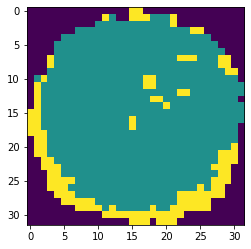

In [ ]:
plt.imshow(np.argmax(x_train[32], axis=2))

# **Save & Load Dataset**

In [ ]:
# saving augmented x and y
dataset_pca_noise = {"y_train": y_train, "y_test": y_test, "x_train": x_train, "x_test": x_test}
with open('dataset_pca.pickle', 'wb') as file:
    pickle.dump(dataset_pca_noise, file)

In [ ]:
with open('dataset_pca.pickle', 'rb') as file:
    dataset_ae = pickle.load(file)

In [ ]:
x_test = dataset_ae.get("x_test")
x_train = dataset_ae.get("x_train")
y_train = dataset_ae.get("y_train")
y_test = dataset_ae.get("y_test")

# **Best Performances**

In [ ]:
cnn = load_model('best_models/Simple_CNN.h5')
alex = load_model('best_models/AlexNet.h5')
vgg = load_model('best_models/Simple_VGG.h5')
vgg16 = load_model('best_models/VGG16.h5')
resnet = load_model('best_models/ResNet.h5')

In [ ]:
cnn_predict = cnn.predict(x_test)
alex_predict = alex.predict(x_test)
vgg_predict = vgg.predict(x_test)
vgg16_predict = vgg16.predict(x_test)
resnet_predict = resnet.predict(x_test)

In [ ]:
y_pred_ = np.ones(len(cnn_predict))
y_test_ = np.ones(len(y_test))
for i in range(len(y_pred_)):
    y_pred_[i] = np.argmax(cnn_predict[i])
    y_test_[i] = np.argmax(y_test_ohe[i])
print(classification_report(y_test_, y_pred_, target_names=labels))

              precision    recall  f1-score   support

      Center       0.68      0.85      0.75        27
    Edge-Loc       0.82      0.80      0.81       104
   Edge-Ring       0.80      0.94      0.86        17
         Loc       0.75      0.78      0.77       102
   Near-full       1.00      1.00      1.00        11
      Random       0.85      0.89      0.87        19
     Scratch       0.61      0.88      0.72        25
        none       0.99      0.97      0.98      1328

    accuracy                           0.94      1633
   macro avg       0.81      0.89      0.85      1633
weighted avg       0.95      0.94      0.94      1633



# **Preprocessing for CNN**

In [ ]:
for i, l in enumerate(labels):
    y_train[y_train==l] = i
y_train_ohe = to_categorical(y_train)
print(y_train_ohe[291])

[0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
for i, l in enumerate(labels):
    y_test[y_test==l] = i
y_test_ohe = to_categorical(y_test)
print(y_test_ohe[291])

[0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
print(x_train.shape, y_train_ohe.shape)

(40310, 32, 32, 3) (40310, 8)


In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch < 10:
        lr = lr
    elif epoch < 30 :
        lr = lr * 0.1
    else:
        lr = lr * 0.01
    print('Learning rate: ', lr)
    return lr

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [ ]:
def plot_confusion_matrix2(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# **Simple CNN**

In [ ]:
data_name = 'PCA'
number = '6'
batch_sizes = 100
weight_decay = 1e-4
epochs = 50
model = "Simple CNN"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [ ]:
input = Input(shape = (32,32,3))

conv_1 = Conv2D(32, (3,3), padding = 'same')(input)
act_1 = Activation('relu')(conv_1)
conv_2 = Conv2D(32, (3,3))(act_1)
act_2 = Activation('relu')(conv_2)
pool_1 = MaxPooling2D(pool_size = (2,2))(act_2)
dropout_1 = Dropout(0.25)(pool_1)

conv_3 = Conv2D(64, (3,3), padding = 'same')(dropout_1)
act_3 = Activation('relu')(conv_3)
conv_4 = Conv2D(64, (3,3))(act_3)
act_4 = Activation('relu')(conv_4)
pool_2 = GlobalAveragePooling2D()(act_4)
dropout_2 = Dropout(0.25)(pool_2)

dense_1 = Dense(512)(dropout_2 )
act_5 = Activation('relu')(dense_1)
dropout_3 = Dropout(0.5)(act_5)
output = Dense(8, activation = 'softmax')(dropout_3)

model0 = Model(inputs = input, outputs = output)

In [ ]:
model0.summary()
# plot_model(model6, show_shapes=True)
filepath =  os.path.join(dir,'model_output',number, 'Simple CNN','{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model0.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model0.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=100, callbacks=callbacks_list, shuffle=True)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_246 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_247 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 15, 15, 32)        0  

In [ ]:
y_predict = model0.predict(x_test)
y_pred_ = np.ones(len(y_predict))
y_test_ = np.ones(len(y_test))
for i in range(len(y_pred_)):
    y_pred_[i] = np.argmax(y_predict[i])
    y_test_[i] = np.argmax(y_test_ohe[i])
print(classification_report(y_test_, y_pred_, target_names=labels))

              precision    recall  f1-score   support

      Center       0.68      0.85      0.75        27
    Edge-Loc       0.82      0.80      0.81       104
   Edge-Ring       0.80      0.94      0.86        17
         Loc       0.75      0.78      0.77       102
   Near-full       1.00      1.00      1.00        11
      Random       0.85      0.89      0.87        19
     Scratch       0.61      0.88      0.72        25
        none       0.99      0.97      0.98      1328

    accuracy                           0.94      1633
   macro avg       0.81      0.89      0.85      1633
weighted avg       0.95      0.94      0.94      1633



In [ ]:
# save_model(model0, 'PCA/best_models/Simple_CNN.h5')

Confusion matrix, without normalization
Normalized confusion matrix


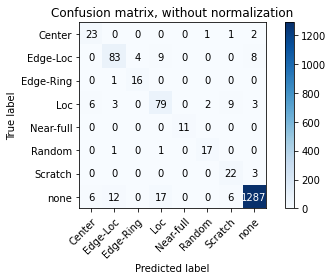

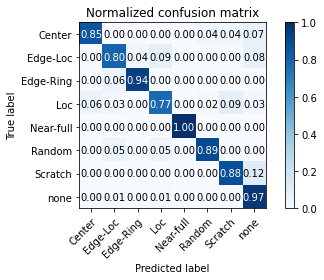

In [ ]:
np.set_printoptions(precision=2)
plot_confusion_matrix2(y_test_, y_pred_, classes=labels, title='Confusion matrix, without normalization')
plot_confusion_matrix2(y_test_, y_pred_, classes=labels, normalize=True, title='Normalized confusion matrix')
plt.show()

# **AlexNet**

In [ ]:
data_name = 'PCA'
number = '6'
batch_sizes = 32
weight_decay = 1e-4
epochs = 50
model = "AlexNet"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [ ]:
# 참고 : https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py

def Alexnet(img_shape=(224, 224, 3), n_classes=10, l2_reg=0., weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(GlobalAveragePooling2D())

	# Layer 6
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [ ]:
model1 = Alexnet(img_shape=(32, 32, 3), n_classes=8)
model1.summary()
# plot_model(model1, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number,'AlexNet','{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', patience=10, mode="min"),
                  LearningRateScheduler(lr_schedule,verbose=1)]
model1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=[['AUC', 'Precision','Recall']])
auto = model1.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=100, callbacks=callbacks_list, shuffle=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_138 (Conv2D)          (None, 32, 32, 96)        34944     
_________________________________________________________________
batch_normalization_97 (Batc (None, 32, 32, 96)        384       
_________________________________________________________________
activation_259 (Activation)  (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 16, 16, 256)       614656    
_________________________________________________________________
batch_normalization_98 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_260 (Activation)  (None, 16, 16, 256)      

In [ ]:
y_predict = model1.predict(x_test)
y_pred_1 = np.ones(len(y_predict))
y_test_ = np.ones(len(y_test))
for i in range(len(y_pred_)):
    y_pred_1[i] = np.argmax(y_predict[i])
    y_test_[i] = np.argmax(y_test_ohe[i])
print(classification_report(y_test_, y_pred_1, target_names=labels))

              precision    recall  f1-score   support

      Center       0.88      0.85      0.87        27
    Edge-Loc       0.84      0.85      0.84       104
   Edge-Ring       0.89      0.94      0.91        17
         Loc       0.78      0.74      0.76       102
   Near-full       0.91      0.91      0.91        11
      Random       0.77      0.89      0.83        19
     Scratch       0.78      0.56      0.65        25
        none       0.97      0.98      0.98      1328

    accuracy                           0.95      1633
   macro avg       0.85      0.84      0.84      1633
weighted avg       0.95      0.95      0.95      1633



In [ ]:
# save_model(alex, 'PCA/best_models/AlexNet.h5')

Confusion matrix, without normalization
Normalized confusion matrix


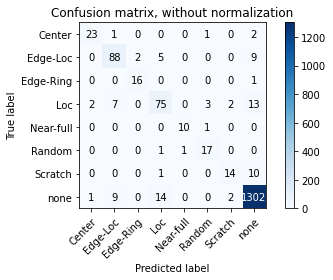

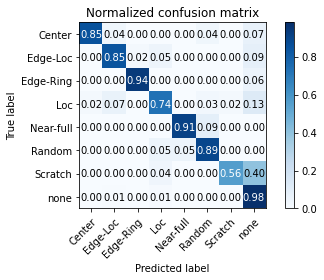

In [ ]:
np.set_printoptions(precision=2)
plot_confusion_matrix2(y_test_, y_pred_1, classes=labels, title='Confusion matrix, without normalization')
plot_confusion_matrix2(y_test_, y_pred_1, classes=labels, normalize=True, title='Normalized confusion matrix')
plt.show()

# **VGGNet**

In [ ]:
data_name = 'PCA'
number = '6'
batch_sizes = 50
weight_decay = 1e-4
epochs = 500 
model = "VGG_simple"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)
lamb = 0.001
drt = 0.4

In [ ]:
def GAP_create_model():
    input_shape = (32, 32, 3)
    input_tensor = Input(input_shape)

    conv_1 = Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu',padding='same')(input_tensor)
    conv_2 = Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu',padding='same')(conv_1)

    pool_1 = MaxPool2D((2,2), name = 'max_pool1')(conv_2)

    conv_3 = Conv2D(128, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(pool_1)
    conv_4 = Conv2D(256, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(conv_3)

    pool_2 = GlobalAveragePooling2D()(conv_4) #GAP layer

    dense_1 = Dense(512, activation='relu')(pool_2)
    drop_1 = Dropout(0.4)(dense_1)
    dense_2 = Dense(256, activation='relu')(drop_1)
    output_tensor = Dense(8, activation='softmax')(dense_2)

    model = Model(input_tensor, output_tensor)
 
    return model

In [ ]:
G_model = GAP_create_model()
filepath =  os.path.join(dir,'model_output',number,'Simple VGG','{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', patience=10, mode='min'),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
G_model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
G_model.summary()
auto = G_model.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=200, callbacks=callbacks_list, shuffle=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pool1 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 global_average_pooling2d (G  (None, 256)              0     

In [ ]:
y_predict = G_model.predict(x_test)
y_pred_3 = np.ones(len(y_predict))
y_test_ = np.ones(len(y_test))
for i in range(len(y_pred_3)):
    y_pred_3[i] = np.argmax(y_predict[i])
    y_test_[i] = np.argmax(y_test_ohe[i])
print(classification_report(y_test_, y_pred_3, target_names=labels))

              precision    recall  f1-score   support

      Center       0.63      0.81      0.71        27
    Edge-Loc       0.91      0.83      0.87       104
   Edge-Ring       0.89      0.94      0.91        17
         Loc       0.75      0.81      0.78       102
   Near-full       1.00      1.00      1.00        11
      Random       0.85      0.89      0.87        19
     Scratch       0.67      0.72      0.69        25
        none       0.98      0.98      0.98      1328

    accuracy                           0.95      1633
   macro avg       0.84      0.87      0.85      1633
weighted avg       0.95      0.95      0.95      1633



In [ ]:
# save_model(G_model, 'PCA/best_models/Simple_VGG.h5')

Confusion matrix, without normalization
Normalized confusion matrix


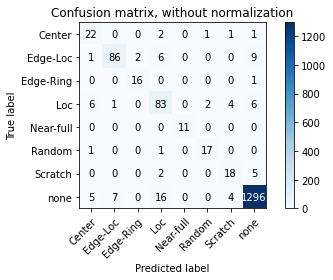

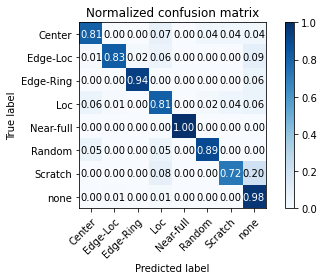

In [ ]:
np.set_printoptions(precision=2)
plot_confusion_matrix2(y_test_, y_pred_3, classes=labels, title='Confusion matrix, without normalization')
plot_confusion_matrix2(y_test_, y_pred_3, classes=labels, normalize=True, title='Normalized confusion matrix')
plt.show()

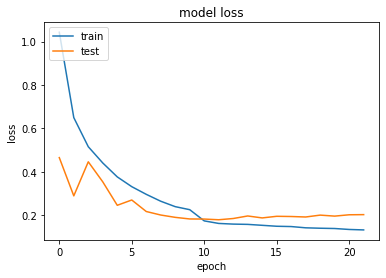

In [ ]:
# loss plot
plt.plot(auto.history['loss'])
plt.plot(auto.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def VGG16(classes=8):

    input_shape = (32, 32, 3)
    input_tensor = Input(input_shape)
    
    # Block 1
    x = Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(input_tensor)
    x = Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    # x = MaxPooling2D((2, 2), name='block4_pool')(x)
    x = GlobalAveragePooling2D(name='gap')(x)

    # Classification block
    # x = Flatten(name='flatten')(x)
    x = Dense(1028, activation='relu', name='fc1')(x)
    x = Dense(1028, activation='relu', name='fc2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Create model.
    model = Model(input_tensor, x, name='mvgg16') 

    return model

In [ ]:
model3 = VGG16(classes=8)
model3.summary()
plot_model(model3, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number,'VGG16','{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', patience=10, mode='min'),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model3.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=300, callbacks=callbacks_list, shuffle=True)

Model: "mvgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0    

In [ ]:
y_predict = model3.predict(x_test) # 11번
y_pred_4 = np.ones(len(y_predict))
for i in range(len(y_pred_4)):
    y_pred_4[i] = np.argmax(y_predict[i])
print(classification_report(y_test_, y_pred_4, target_names=labels))

              precision    recall  f1-score   support

      Center       0.79      0.70      0.75        27
    Edge-Loc       0.87      0.84      0.85       104
   Edge-Ring       0.80      0.94      0.86        17
         Loc       0.72      0.71      0.71       102
   Near-full       1.00      0.82      0.90        11
      Random       0.75      0.95      0.84        19
     Scratch       0.61      0.68      0.64        25
        none       0.98      0.98      0.98      1328

    accuracy                           0.94      1633
   macro avg       0.81      0.83      0.82      1633
weighted avg       0.94      0.94      0.94      1633



Confusion matrix, without normalization
Normalized confusion matrix


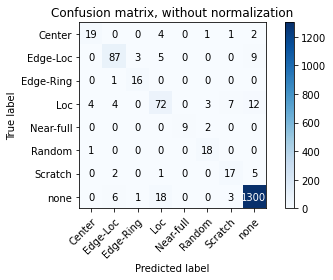

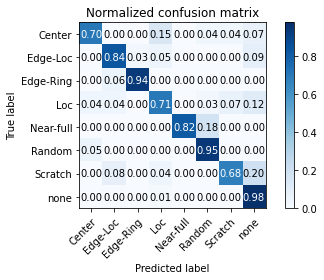

In [ ]:
np.set_printoptions(precision=2)
plot_confusion_matrix2(y_test_, y_pred_4, classes=labels, title='Confusion matrix, without normalization')
plot_confusion_matrix2(y_test_, y_pred_4, classes=labels, normalize=True, title='Normalized confusion matrix')
plt.show()

# **ResNet50**

In [ ]:
data_name = 'PCA'
number = '5'
batch_sizes = 32
weight_decay = 1e-4
epochs = 50
model = "ResNet"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:
def ResNet50(input_shape = (27, 27, 3), classes = 9):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)
    
    # Stage 1
    X = Conv2D(64, (3, 3), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32,32,128], stage=2, block='b')
    X = identity_block(X, 3, [32,32,128], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=4, block='b')
    X = identity_block(X, 3, [128,128,512], stage=4, block='c')
    X = identity_block(X, 3, [128,128,512], stage=4, block='d')
    X = identity_block(X, 3, [128,128,512], stage=4, block='e')
    X = identity_block(X, 3, [128,128,512], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    # X = AveragePooling2D(pool_size=(2,2), name = "avg_pool")(X)
    X = GlobalAveragePooling2D(name = "avg_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    # X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
# ResNet50
model5 = ResNet50(input_shape = (32, 32, 3), classes = 8)
model5.summary()
# plot_model(model5, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number, 'ResNet','{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model5.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model5.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=200, callbacks=callbacks_list, shuffle=True)

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_22 (ZeroPadding2 (None, 34, 34, 3)    0           input_31[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   1792        zero_padding2d_22[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
y_predict = model5.predict(x_test)
y_pred_5 = np.ones(len(y_predict))
for i in range(len(y_pred_5)):
    y_pred_5[i] = np.argmax(y_predict[i])
print(classification_report(y_test_, y_pred_5, target_names=labels))

              precision    recall  f1-score   support

      Center       0.91      0.78      0.84        27
    Edge-Loc       0.89      0.78      0.83       104
   Edge-Ring       0.80      0.94      0.86        17
         Loc       0.83      0.71      0.76       102
   Near-full       1.00      1.00      1.00        11
      Random       0.74      0.89      0.81        19
     Scratch       0.68      0.60      0.64        25
        none       0.97      0.99      0.98      1328

    accuracy                           0.95      1633
   macro avg       0.85      0.84      0.84      1633
weighted avg       0.95      0.95      0.94      1633



In [ ]:
# save_model(model5, 'PCA/best_models/ResNet.h5')

Confusion matrix, without normalization
Normalized confusion matrix


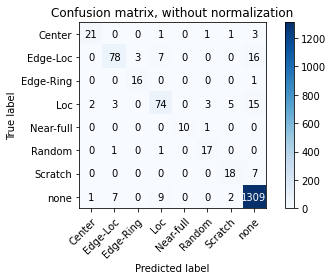

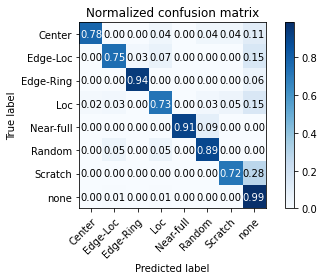

In [ ]:
np.set_printoptions(precision=2)
plot_confusion_matrix2(y_test_, y_pred_5, classes=labels, title='Confusion matrix, without normalization')
plot_confusion_matrix2(y_test_, y_pred_5, classes=labels, normalize=True, title='Normalized confusion matrix')
plt.show()